In [2]:
%matplotlib inline

import scipy as sci
import scipy.special as sp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colors
from matplotlib.patches import Rectangle, Circle
from sklearn.linear_model import OrthogonalMatchingPursuit
import cvxpy as cp
import librosa
import librosa.display
from scipy.fft import fft, ifft, fftfreq
from scipy import signal

def db(x):
    return 20*np.log10(np.absolute(x))

#Spherical Hankel function of second kind
def hn2(n, x, derivative=True):
    if derivative:
        h = sp.spherical_jn(n, x, derivative=True) - 1j*sp.spherical_yn(n, x, derivative=True)
    else:
        h = sp.spherical_jn(n, x) - 1j*sp.spherical_yn(n, x)
    
    return h
                
def Rn(n, kr, kr_a):
    rn = 4*np.pi*((1j)**n)*(sp.spherical_jn(n, kr) - hn2(n, kr, derivative=False)*sp.spherical_jn(n, kr_a, derivative=True)/hn2(n, kr_a, derivative=True))
    
    return rn

#Matrix of Spherical Harmonics
def harm(N, theta, phi):
    Q = theta.shape[0]
    Y = np.zeros((Q, N+1, (2*N+1)+1), dtype='complex')
    
    for q in range(Q):
        for n in range(N+1):
            for m in range(2*n+1):
                Y[q][n][m] = sp.sph_harm(m-n, n, phi[q], theta[q])
                
    return Y

#The sound pressure can be obtained with (mic=True) or without (mic=False) the presence of a rigid microphone array
def pressure(kr, kr_a, Y, a_s, Y_s, mic):
    N = Y.shape[1] - 1
    p = np.zeros((Y.shape[0],1), dtype=complex)
    
    for i in range(Y.shape[0]):
        sum_n = 0
        
        for n in range(N+1):
            sum_m = 0
            if mic:
                R = Rn(n, kr, kr_a)
            else:
                R = 4*np.pi*((1j)**n)*sp.spherical_jn(n, kr)
                
            for m in range(2*n+1):
                sum_s = 0
                
                for s in range(a_s.shape[0]):
                    sum_s = sum_s + a_s[s]*np.conj(Y_s[s][n][m])
                
                sum_m = sum_m + sum_s*R*Y[i][n][m]

            sum_n = sum_n + sum_m

        p[i][0] = sum_n
        
    return p

#p_nm Spherical Fourier Transform coefficients of the sound pressure
def fourier(p, Y):
    N = Y.shape[1] - 1
    Q = p.shape[0]
    pnm = np.zeros((N+1, (2*N+1)+1), dtype='complex')
    
    for n in range(N+1):
        for m in range(2*n+1):
            sum_q = 0

            for q in range(Q):
                sum_q = sum_q + p[q][0]*np.conjugate(Y[q][n][m])

            pnm[n][m] = (4*np.pi/Q)*sum_q
        
    return pnm

def beam(kr, kr_a, pnm):
    N = pnm.shape[0] - 1
    delta = 100
    theta_v = np.arange(0, np.pi + np.pi/delta, np.pi/delta)
    phi_v = np.arange(0, 2*np.pi + 2*np.pi/delta, 2*np.pi/delta)
    b = np.zeros((delta + 1, delta + 1), dtype='complex')
    
    for i in range(delta + 1):
        for j in range(delta + 1):
            sum_n = 0

            for n in range(N+1):
                R = Rn(n, kr, kr_a)
                sum_m = 0

                for m in range(2*n+1):
                    sum_m = sum_m + pnm[n][m]*sp.sph_harm(m-n, n, phi_v[j], theta_v[i])

                sum_n = sum_n + sum_m/R

            b[i][j] = sum_n

    return theta_v, phi_v, b

#Nearly-uniform ditribuition over a sphere
def dist(num_points):
    indices = np.arange(0, num_points, dtype=float) + 0.5
    theta = np.arccos(1 - 2*indices/num_points)%(np.pi)
    phi = (np.pi * (1 + 5**0.5) * indices)%(2*np.pi)
    
    return theta, phi

def sens_matrix(kr, kr_a, Y_l, Y_q):
    N = Y_l.shape[1] - 1
    L = Y_l.shape[0]
    Q = Y_q.shape[0]
    A = np.zeros((Q, L), dtype='complex')
    
    for i in range(Q):
        for j in range(L):
            sum_n = 0
            
            for n in range(N+1):
                R = Rn(n, kr, kr_a)
                sum_m = 0
                
                for m in range(2*n+1):
                    sum_m = sum_m + np.conjugate(Y_l[j][n][m])*Y_q[i][n][m]
                
                sum_m = sum_m*R
                sum_n = sum_m + sum_n
                
            A[i][j] = sum_n

    return A

def gram(A):
    G = np.zeros((A.shape[1],A.shape[1]))

    for i in range(A.shape[1]):
        C = i + 1
        for j in range(C):
            num = np.linalg.norm(np.dot(np.conjugate(A[:,i]).T,A[:,j]))
            den = np.linalg.norm(A[:,i])*np.linalg.norm(A[:,j])
            G[i][j] = num/den
            G[j][i] = G[i][j]
            
    return G

def l2(p, A, e):
    delta = 1e-6
    L = A.shape[1]
    b_est = cp.Variable(shape=(L,1), complex=True)
    
    if e == 0:
        constraints = [A*b_est == p]
    else:
        constraints = [cp.norm(p - A*b_est, 2) <= e]
    obj = cp.Minimize(cp.norm(b_est, 2)**2)
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.ECOS)
    print("status: {}".format(prob.status))
    
    return b_est.value

def l1(p, A, e):
    delta = 1e-6
    L = A.shape[1]
    b_est = cp.Variable(shape=(L,1), complex=True)

    if e == 0:
        constraints = [A*b_est == p]
    else:
        constraints = [cp.norm(p - A*b_est, 2) <= e]
    obj = cp.Minimize(cp.norm(b_est, 1))
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.ECOS)
    print("status: {}".format(prob.status))
    
    return b_est.value

def LASSO(p, A):
    L = A.shape[1]
    lmbd_max = np.max(abs(np.matmul(np.conjugate(A.T), p)))
    print('lambda max = ', lmbd_max)
    lmbd = np.arange(0, np.int(lmbd_max)+1.1, 0.1)
    non_zeros = np.zeros((lmbd.shape[0]))
    amp = np.zeros((L, 1, lmbd.shape[0]))

    for i in range(lmbd.shape[0]):
        delta = 1e-6
        b_est = cp.Variable(shape=(L,1), complex=True)

        obj = cp.Minimize(lmbd[i]*cp.norm(b_est, 1) + (1/2)*cp.norm(p- A*b_est, 2)**2)
        prob = cp.Problem(obj)
        prob.solve(solver=cp.ECOS)

        non_zeros[i] = np.where(abs(b_est.value) >= delta)[0][:].shape[0]
        amp[:,:,i] = abs(b_est.value)
        
    return non_zeros, amp

def OMP(S, p, A):
    Q = p.shape[0]
    Ã = np.zeros((Q, S), dtype='complex')
    r = np.copy(p)
    U = np.zeros((S))
    L = A.shape[1]
    b_est = np.zeros((L,1), dtype='complex')
    delta = 1e-6

    for i in range(S):
        g = np.argmax(abs(np.matmul(np.conjugate(A.T),r)))
        U[i] = g
        Ã[:,[i]] = A[:,[g]]
        
        x = cp.Variable(shape=(i+1,1), complex=True)
        obj = cp.Minimize(cp.norm(p - Ã[:,:i+1]*x, 2))
        prob = cp.Problem(obj)
        prob.solve(solver=cp.ECOS)
        
        r = p - np.matmul(Ã[:,:i+1],x.value)
        
    for i in range(S):
        b_est[np.int(U[i])][0] = x.value[i][0]
        
    return b_est

The recording of a sound scene with a spherical array of 64 microphones and a source located 2m away from the array is made in an anechoic chamber, which had a reflexion spot on the ceiling. The source emitted a sine sweep from 20Hz to 20000Hz.

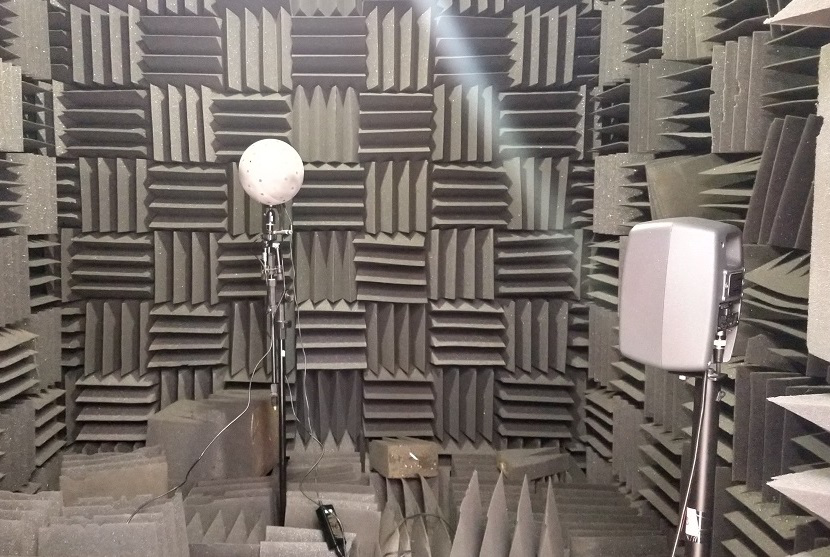

In [4]:
from PIL import Image

im = Image.open('setup.jpg')
im

# Crosscorrelation

In [6]:
x, fs = librosa.load('1-201016_0957.wav', sr=44100)
sweep, fs = librosa.load('sweep.wav', sr=44100)
ts = np.array (range(len(sweep)))/float(fs)

b = np.argmax(signal.correlate(x, sweep))
delta = b - sweep.shape[0]
delta

156024

# Sound Pressure

In [7]:
aux = sweep.shape[0]
t = ts[np.int(fs/10):np.int(fs/5)]
mic_fft = np.zeros((64, t.shape[0]), dtype='complex')

for i in range(1,65):
    x, fs = librosa.load('%d-201016_0957.wav' %i, sr=44100)
    mic = x[150000:aux+150000]
    time = np.arange(0, aux, 1)
    fft_sweep = fft(sweep)
    fft_mic = fft(mic)
    imp = ifft(fft_mic/fft_sweep)
    imp = imp - np.mean(imp)
    imp = imp[np.int(fs/10):np.int(fs/5)]
    mic_fft[i-1][:] = fft(imp)

# Noise energy

In [9]:
t = ts[np.int(fs/10):np.int(fs/5)]
noise_fft = np.zeros((64,44100-22050), dtype='complex')

for i in range(1,65):
    x, fs = librosa.load('%d-201016_0957.wav' %i, sr=44100)
    noise = x[22050:44100]
    noise_fft[i-1][:] = fft(noise)
    
noise_2 = np.zeros(noise_fft.shape[1])

for i in range (noise_2.shape[0]):
    noise_2[i] = cp.norm(noise_fft[:,i], 2).value
    
np.mean(noise_2)

0.11800549573040749

# Spherical Array and Grid Points

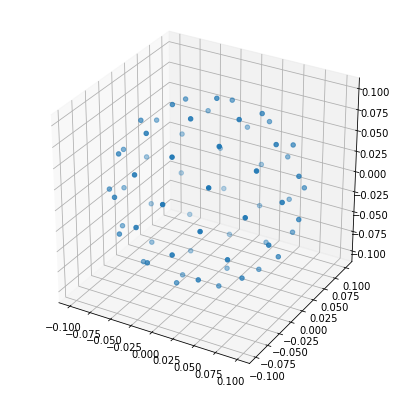

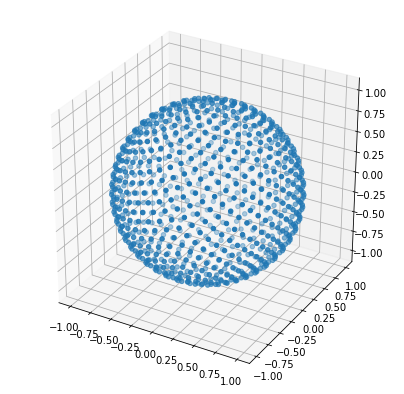

In [14]:
Q = 64
N = 7

x_q = (1/1000)*np.array([92.87248504,97.24271681,92.94052753,67.76347524,46.46820924,9.15285677,16.67688232,-5.02914291,15.54210645,58.27853799,87.33600863,99.64542893,82.59577720,54.98970389,42.95035361,79.02718715,-0.95586134,33.60658337,65.84915205,78.68947327,74.95342300,72.69378055,38.47902000,28.04341953,-6.36020205,-37.96648209,-28.46820656,-51.81530182,-32.00307464,-17.18304345,31.60049464,66.12742186,-70.72036899,-83.65437631,-63.99281989,-46.44820610,-20.03621256,16.15417190,44.44449497,44.58369652,38.21016357,36.50458513,-3.30370367,-7.84654566,-43.40076966,-71.53207421,-95.16399794,-99.14743134,-81.93215260,-61.10065065,-25.65629260,4.49213395,-0.13248193,-3.55622011,-40.39615447,-49.62396458,-82.56077519,-98.00533545,-91.06001434,-63.61670849,-37.22899828,-44.36537931,-76.03920334,-77.61214918])
y_q = (1/1000)*np.array([-36.54799424,-17.67997233,25.97133639,60.22745018,89.60055179,100.31343530,83.80176637,56.78680720,15.35626685,7.29231653,-4.83700272,15.04420678,59.14819629,78.69874437,50.89088147,41.71228922,-61.29577860,-76.02460980,-73.02330695,-60.47573286,-31.47270636,13.44345713,46.16821875,81.86019988,96.70967011,94.19130453,85.44255118,52.16757609,20.29114238,-21.82779295,-30.33225330,-43.16196807,66.52571410,24.86705551,-6.83777624,-52.21818834,-87.10854741,-97.90565638,-90.71169051,-73.94625110,-41.98628516,1.34798521,25.61073808,65.94052756,77.22054084,70.14732512,35.54664859,-4.27623468,-35.83554645,-74.50518837,-98.29817356,-95.82336771,-69.21793652,-26.77784208,-0.89497560,41.14665773,36.55508289,-5.28656196,-45.05313807,-78.06984296,-80.86758033,-45.94490308,-5.12352453,-46.65830663])
z_q = (1/1000)*np.array([-19.01330166,23.53364837,31.78219672,45.86202861,11.61923617,-13.26649557,-54.97004229,-84.09831300,-99.22292072,-82.90352302,-51.68737758,-12.92363476,-1.41012952,-33.24454994,-76.73294800,-48.34613345,-81.02144071,-58.42444916,-25.57431947,21.75344873,60.94270370,69.69539246,81.91715691,53.24504012,30.48520193,-3.01734788,-47.02862599,-70.11617861,-94.26893844,-97.72845273,-91.67291393,-63.92783893,-29.92521968,-52.02052358,-78.61757958,-73.74540634,-48.30332446,-21.81937624,10.89201869,53.54256207,84.25968941,94.80589750,98.26360281,76.89498388,49.75863005,16.88416823,-1.67608756,-21.77293449,-48.22339662,-32.22184656,-1.33556193,33.47032914,74.37351486,97.94314918,93.21968527,78.53008784,46.58330510,26.25959796,-0.92116138,13.43778337,48.95912723,79.01480241,67.18890571,46.06426731])

r_a = np.sqrt(x_q[0]**2 + y_q[0]**2 + z_q[0]**2)
phi_q = np.arctan2(y_q, x_q)
theta_q = np.arccos(z_q/np.sqrt(x_q**2 + y_q**2 + z_q**2))
Y_q = harm(N, theta_q, phi_q)

plt.figure(figsize=(7,7)).add_subplot(111, projection='3d').scatter(x_q, y_q, z_q);
plt.show()

L = 900
theta_l, phi_l = dist(L)
Y_l = harm(N, theta_l, phi_l)

x, y, z = np.cos(phi_l)*np.sin(theta_l), np.sin(phi_l)*np.sin(theta_l), np.cos(theta_l);

plt.figure(figsize=(7,7)).add_subplot(111, projection='3d').scatter(x, y, z);
plt.show()

# 3500 Hz 

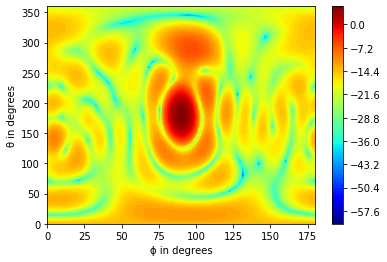

In [21]:
f = 3500
aux = np.int(f/10)
c = 340
k = 2*np.pi*f/c

p = np.zeros((64,1), dtype=complex)
p[:,0] = mic_fft[:,aux]

pnm = fourier(p, Y_q)
A = sens_matrix(k*r_a, k*r_a, Y_l, Y_q)
phi_v, theta_v, b = beam(k*r_a, k*r_a, pnm)

plt.figure(figsize=(6,4))
cs = plt.contourf((180/np.pi)*phi_v, (180/np.pi)*theta_v, db(b), 100, cmap='jet')
cbar= plt.colorbar()
plt.ylabel('θ in degrees')
plt.xlabel('ϕ in degrees')
plt.show()

### L1-norm minimization

status: optimal


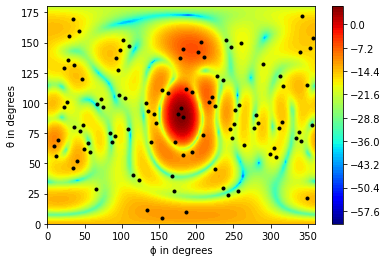

In [22]:
e = 0.11800549573040749
b_l1 = l1(p, A, e)
p_l1 = np.matmul(A, b_l1)
pnm = fourier(p_l1, Y_q)
theta_v, phi_v, img = beam(k*r_a, k*r_a, pnm)

#A treshold is chosen to show the results
D = np.where(np.absolute(b_l1) >= 1e-6)[0][:].shape[0]

plt.figure(figsize=(6,4))
for i in range(D):
    aux = np.where(np.absolute(b_l1) >= 1e-6)[0][i]
    plt.plot((180/np.pi)*phi_l[aux], (180/np.pi)*theta_l[aux], 'k.')

cs = plt.contourf((180/np.pi)*phi_v, (180/np.pi)*theta_v, db(img), 100, cmap='jet')
cbar = plt.colorbar()
plt.ylabel('θ in degrees')
plt.xlabel('ϕ in degrees')
plt.show()

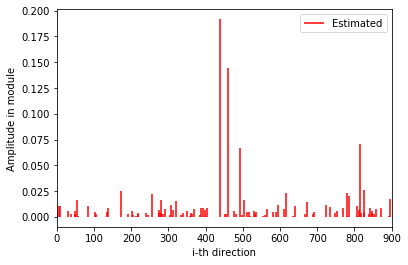

In [33]:
x = np.zeros((D))
y = np.zeros((D))

for i in range(D):
    l = np.where(abs(b_l1) > 1e-6)[0][i]
    x[i] = l
    y[i] = abs(b_l1[l][0])

plt.figure(figsize=(6,4))
plt.vlines(x, ymin=0, ymax=y, colors='r')

plt.legend(('Estimated', '-'),loc='upper right')
plt.ylabel('Amplitude in module')
plt.xlabel('i-th direction')
plt.xticks(np.arange(0, 1000, 100))
plt.xlim(0,900)
plt.show()

### LASSO

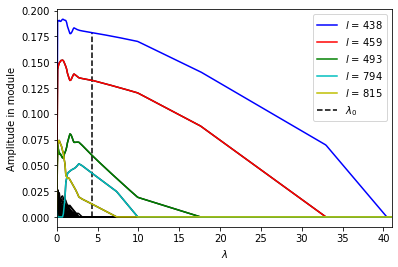

In [37]:
non_zeros, amp = LASSO(p, A)
lmbd_max = np.max(abs(np.matmul(np.conjugate(A.T), p)))
lmbd = np.arange(0, np.int(lmbd_max)+1.1, 0.1)
plt.figure(figsize=(6,4))
for i in range(L):
    if i != 438 & i != 459 & i != 493 & i != 794 & i != 815:
        plt.plot(lmbd, np.absolute(amp[i][0][:]), 'k')
plt.plot(lmbd, np.absolute(amp[438][0][:]), 'b', label='$l$ = 438')
plt.plot(lmbd, np.absolute(amp[459][0][:]), 'r', label='$l$ = 459')
plt.plot(lmbd, np.absolute(amp[493][0][:]), 'g', label='$l$ = 493')
plt.plot(lmbd, np.absolute(amp[794][0][:]), 'c', label='$l$ = 794')
plt.plot(lmbd, np.absolute(amp[815][0][:]), 'y', label='$l$ = 815')
plt.vlines(4.33, 0, 0.17852093, colors='k', linestyles='dashed', label='$\lambda_0$')
plt.ylabel('Amplitude in module')
plt.xlabel('$\lambda$')
plt.xticks(np.arange(0,41,5))
plt.xlim(0,41)
plt.legend(loc='upper right')

### Orthogonal Matching Pursuit

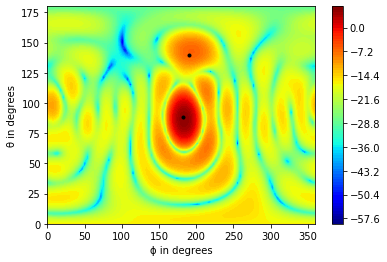

In [38]:
b_omp = OMP(2, p, A)
p_omp = np.matmul(A, b_omp)
pnm = fourier(p_omp, Y_q)
theta_v, phi_v, img = beam(k*r_a, k*r_a, pnm)

D = np.where(np.absolute(b_omp) >= 1e-6)[0][:].shape[0]

plt.figure(figsize=(6,4))
for i in range(D):
    aux = np.where(np.absolute(b_omp) >= 1e-6)[0][i]
    plt.plot((180/np.pi)*phi_l[aux], (180/np.pi)*theta_l[aux], 'k.')

cs = plt.contourf((180/np.pi)*phi_v, (180/np.pi)*theta_v, db(img), 100, cmap='jet')
cbar = plt.colorbar()
plt.ylabel('θ in degrees')
plt.xlabel('ϕ in degrees')
plt.show()

# 1000 Hz

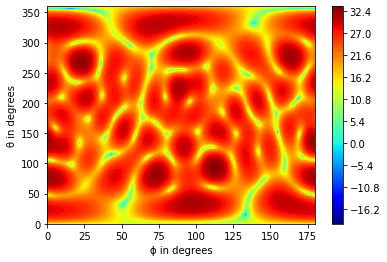

In [39]:
f = 1000
aux = np.int(f/10)
c = 340
k = 2*np.pi*f/c

p = np.zeros((64,1), dtype=complex)
p[:,0] = mic_fft[:,aux]

pnm = fourier(p, Y_q)
A = sens_matrix(k*r_a, k*r_a, Y_l, Y_q)
phi_v, theta_v, b = beam(k*r_a, k*r_a, pnm)

plt.figure(figsize=(6,4))
cs = plt.contourf((180/np.pi)*phi_v, (180/np.pi)*theta_v, db(b), 100, cmap='jet')
cbar= plt.colorbar()
plt.ylabel('θ in degrees')
plt.xlabel('ϕ in degrees')
plt.show()

### L1-norm minimization

status: optimal


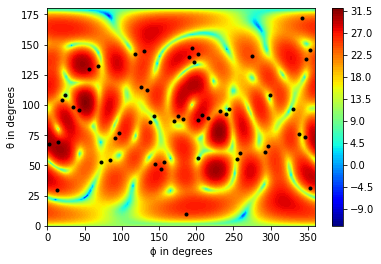

In [40]:
b_l1 = l1(p, A, e)
p_l1 = np.matmul(A, b_l1)
pnm = fourier(p_l1, Y_q)
theta_v, phi_v, img = beam(k*r_a, k*r_a, pnm)

#A treshold is chosen to show the results
D = np.where(np.absolute(b_l1) >= 1e-6)[0][:].shape[0]

plt.figure(figsize=(6,4))
for i in range(D):
    aux = np.where(np.absolute(b_l1) >= 1e-6)[0][i]
    plt.plot((180/np.pi)*phi_l[aux], (180/np.pi)*theta_l[aux], 'k.')

cs = plt.contourf((180/np.pi)*phi_v, (180/np.pi)*theta_v, db(img), 100, cmap='jet')
cbar = plt.colorbar()
plt.ylabel('θ in degrees')
plt.xlabel('ϕ in degrees')
plt.show()

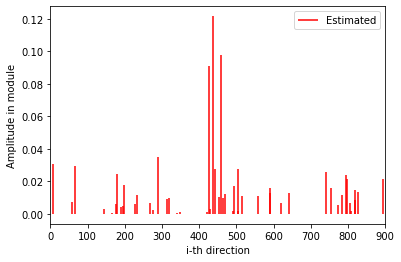

In [43]:
x = np.zeros((D))
y = np.zeros((D))

for i in range(D):
    l = np.where(abs(b_l1) > 1e-6)[0][i]
    x[i] = l
    y[i] = abs(b_l1[l][0])

plt.figure(figsize=(6,4))
plt.vlines(x, ymin=0, ymax=y, colors='r')

plt.legend(('Estimated', '-'),loc='upper right')
plt.ylabel('Amplitude in module')
plt.xlabel('i-th direction')
plt.xticks(np.arange(0, 1000, 100))
plt.xlim(0,900)
plt.show()

### LASSO

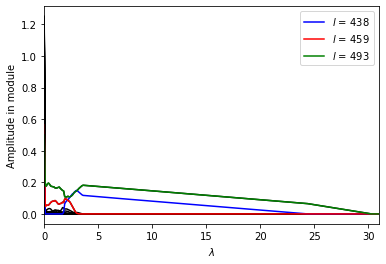

In [48]:
non_zeros, amp = LASSO(p, A)
lmbd_max = np.max(abs(np.matmul(np.conjugate(A.T), p)))
lmbd = np.arange(0, np.int(lmbd_max)+1.1, 0.1)
plt.figure(figsize=(6,4))
for i in range(L):
    if i != 438 & i != 459 & i != 493:
        plt.plot(lmbd, np.absolute(amp[i][0][:]), 'k')
plt.plot(lmbd, np.absolute(amp[438][0][:]), 'b', label='$l$ = 438')
plt.plot(lmbd, np.absolute(amp[459][0][:]), 'r', label='$l$ = 459')
plt.plot(lmbd, np.absolute(amp[493][0][:]), 'g', label='$l$ = 493')
plt.xticks(np.arange(0,31,5))
plt.xlim(0,31)
plt.ylabel('Amplitude in module')
plt.xlabel('$\lambda$')
plt.legend(loc='upper right')

### Orthogonal Matching Pursuit

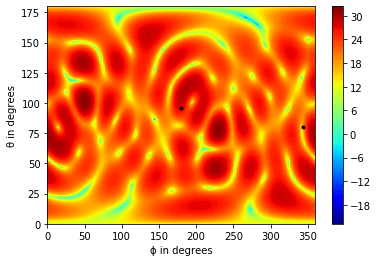

In [49]:
b_omp = OMP(2, p, A)
p_omp = np.matmul(A, b_omp)
pnm = fourier(p_omp, Y_q)
theta_v, phi_v, img = beam(k*r_a, k*r_a, pnm)

D = np.where(np.absolute(b_omp) >= 1e-6)[0][:].shape[0]

plt.figure(figsize=(6,4))
for i in range(D):
    aux = np.where(np.absolute(b_omp) >= 1e-6)[0][i]
    plt.plot((180/np.pi)*phi_l[aux], (180/np.pi)*theta_l[aux], 'k.')

cs = plt.contourf((180/np.pi)*phi_v, (180/np.pi)*theta_v, db(img), 100, cmap='jet')
cbar = plt.colorbar()
plt.ylabel('θ in degrees')
plt.xlabel('ϕ in degrees')
plt.show()

# 6000 Hz

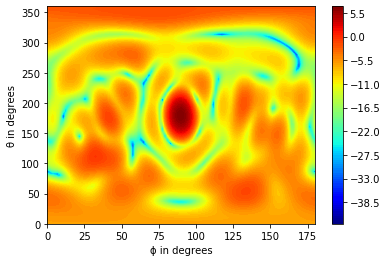

In [50]:
f = 6000
aux = np.int(f/10)
c = 340
k = 2*np.pi*f/c

p = np.zeros((64,1), dtype=complex)
p[:,0] = mic_fft[:,aux]

pnm = fourier(p, Y_q)
A = sens_matrix(k*r_a, k*r_a, Y_l, Y_q)
phi_v, theta_v, b = beam(k*r_a, k*r_a, pnm)

plt.figure(figsize=(6,4))
cs = plt.contourf((180/np.pi)*phi_v, (180/np.pi)*theta_v, db(b), 100, cmap='jet')
cbar= plt.colorbar()
plt.ylabel('θ in degrees')
plt.xlabel('ϕ in degrees')
plt.show()

### L1-norm minimization

status: optimal


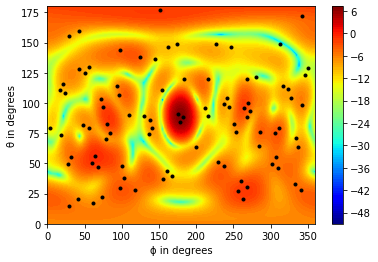

In [51]:
b_l1 = l1(p, A, e)
p_l1 = np.matmul(A, b_l1)
pnm = fourier(p_l1, Y_q)
theta_v, phi_v, img = beam(k*r_a, k*r_a, pnm)

#A treshold is chosen to show the results
D = np.where(np.absolute(b_l1) >= 1e-6)[0][:].shape[0]

plt.figure(figsize=(6,4))
for i in range(D):
    aux = np.where(np.absolute(b_l1) >= 1e-6)[0][i]
    plt.plot((180/np.pi)*phi_l[aux], (180/np.pi)*theta_l[aux], 'k.')

cs = plt.contourf((180/np.pi)*phi_v, (180/np.pi)*theta_v, db(img), 100, cmap='jet')
cbar = plt.colorbar()
plt.ylabel('θ in degrees')
plt.xlabel('ϕ in degrees')
plt.show()

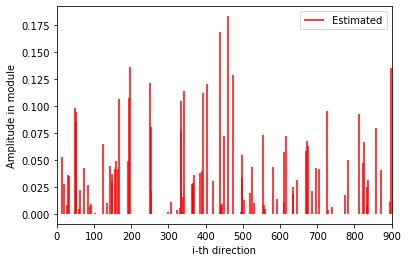

In [52]:
x = np.zeros((D))
y = np.zeros((D))

for i in range(D):
    l = np.where(abs(b_l1) > 1e-6)[0][i]
    x[i] = l
    y[i] = abs(b_l1[l][0])

plt.figure(figsize=(6,4))
plt.vlines(x, ymin=0, ymax=y, colors='r')

plt.legend(('Estimated', '-'),loc='upper right')
plt.ylabel('Amplitude in module')
plt.xlabel('i-th direction')
plt.xticks(np.arange(0, 1000, 100))
plt.xlim(0,900)
plt.show()

### LASSO

lambda max =  15.564912370551712


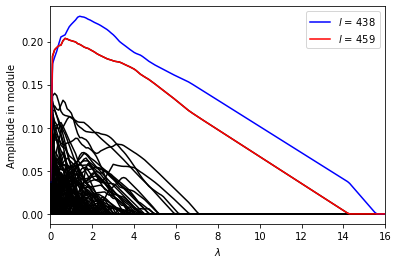

In [53]:
non_zeros, amp = LASSO(p, A)
lmbd_max = np.max(abs(np.matmul(np.conjugate(A.T), p)))
lmbd = np.arange(0, np.int(lmbd_max)+1.1, 0.1)
plt.figure(figsize=(6,4))
for i in range(L):
    if i != 438 & i != 459:
        plt.plot(lmbd, np.absolute(amp[i][0][:]), 'k')
plt.plot(lmbd, np.absolute(amp[438][0][:]), 'b', label='$l$ = 438')
plt.plot(lmbd, np.absolute(amp[459][0][:]), 'r', label='$l$ = 459')
plt.xticks(np.arange(0,18,2))
plt.xlim(0,16)
plt.ylabel('Amplitude in module')
plt.xlabel('$\lambda$')
plt.legend(loc='upper right')

### Orthogonal Matching Pursuit

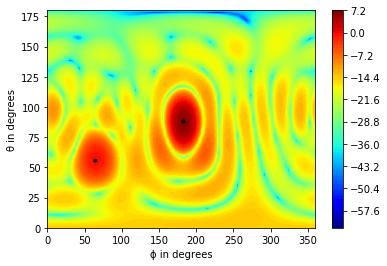

In [54]:
b_omp = OMP(2, p, A)
p_omp = np.matmul(A, b_omp)
pnm = fourier(p_omp, Y_q)
theta_v, phi_v, img = beam(k*r_a, k*r_a, pnm)

D = np.where(np.absolute(b_omp) >= 1e-6)[0][:].shape[0]

plt.figure(figsize=(6,4))
for i in range(D):
    aux = np.where(np.absolute(b_omp) >= 1e-6)[0][i]
    plt.plot((180/np.pi)*phi_l[aux], (180/np.pi)*theta_l[aux], 'k.')

cs = plt.contourf((180/np.pi)*phi_v, (180/np.pi)*theta_v, db(img), 100, cmap='jet')
cbar = plt.colorbar()
plt.ylabel('θ in degrees')
plt.xlabel('ϕ in degrees')
plt.show()

# 10000 Hz

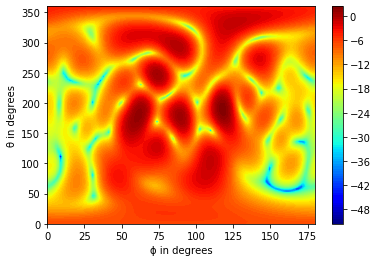

In [55]:
f = 10000
aux = np.int(f/10)
c = 340
k = 2*np.pi*f/c

p = np.zeros((64,1), dtype=complex)
p[:,0] = mic_fft[:,aux]

pnm = fourier(p, Y_q)
A = sens_matrix(k*r_a, k*r_a, Y_l, Y_q)
phi_v, theta_v, b = beam(k*r_a, k*r_a, pnm)

plt.figure(figsize=(6,4))
cs = plt.contourf((180/np.pi)*phi_v, (180/np.pi)*theta_v, db(b), 100, cmap='jet')
cbar= plt.colorbar()
plt.ylabel('θ in degrees')
plt.xlabel('ϕ in degrees')
plt.show()

### L1-norm minimization

status: optimal


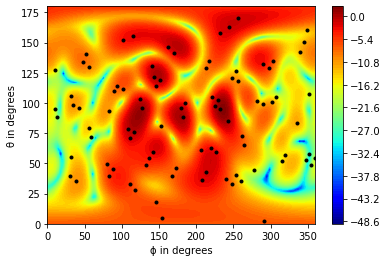

In [56]:
b_l1 = l1(p, A, e)
p_l1 = np.matmul(A, b_l1)
pnm = fourier(p_l1, Y_q)
theta_v, phi_v, img = beam(k*r_a, k*r_a, pnm)

#A treshold is chosen to show the results
D = np.where(np.absolute(b_l1) >= 1e-6)[0][:].shape[0]

plt.figure(figsize=(6,4))
for i in range(D):
    aux = np.where(np.absolute(b_l1) >= 1e-6)[0][i]
    plt.plot((180/np.pi)*phi_l[aux], (180/np.pi)*theta_l[aux], 'k.')

cs = plt.contourf((180/np.pi)*phi_v, (180/np.pi)*theta_v, db(img), 100, cmap='jet')
cbar = plt.colorbar()
plt.ylabel('θ in degrees')
plt.xlabel('ϕ in degrees')
plt.show()

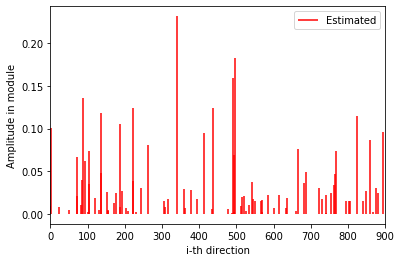

In [58]:
x = np.zeros((D))
y = np.zeros((D))

for i in range(D):
    l = np.where(abs(b_l1) > 1e-6)[0][i]
    x[i] = l
    y[i] = abs(b_l1[l][0])

plt.figure(figsize=(6,4))
plt.vlines(x, ymin=0, ymax=y, colors='r')

plt.legend(('Estimated','-'),loc='upper right')
plt.ylabel('Amplitude in module')
plt.xlabel('i-th direction')
plt.xticks(np.arange(0, 1000, 100))
plt.xlim(0,900)
plt.show()

### LASSO

(0, 4)

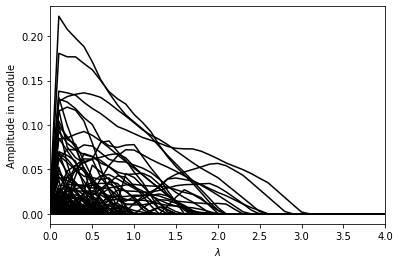

In [60]:
non_zeros, amp = LASSO(p, A)
lmbd_max = np.max(abs(np.matmul(np.conjugate(A.T), p)))
lmbd = np.arange(0, np.int(lmbd_max)+1.1, 0.1)
plt.figure(figsize=(6,4))
for i in range(L):
    plt.plot(lmbd, np.absolute(amp[i][0][:]), 'k')
plt.ylabel('Amplitude in module')
plt.xlabel('$\lambda$')
plt.xticks(np.arange(0,4.5,0.5))
plt.xlim(0,4)

### Orthogonal Matching Pursuit

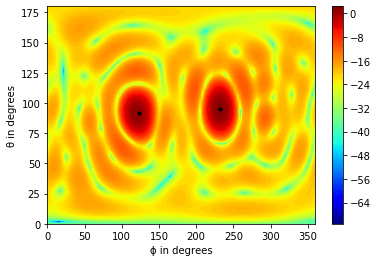

In [61]:
b_omp = OMP(2, p, A)
p_omp = np.matmul(A, b_omp)
pnm = fourier(p_omp, Y_q)
theta_v, phi_v, img = beam(k*r_a, k*r_a, pnm)

D = np.where(np.absolute(b_omp) >= 1e-6)[0][:].shape[0]

plt.figure(figsize=(6,4))
for i in range(D):
    aux = np.where(np.absolute(b_omp) >= 1e-6)[0][i]
    plt.plot((180/np.pi)*phi_l[aux], (180/np.pi)*theta_l[aux], 'k.')

cs = plt.contourf((180/np.pi)*phi_v, (180/np.pi)*theta_v, db(img), 100, cmap='jet')
cbar = plt.colorbar()
plt.ylabel('θ in degrees')
plt.xlabel('ϕ in degrees')
plt.show()